<a href="https://colab.research.google.com/github/Jangsehawn/PaperCompetition_ElectricityDemandForecast/blob/master/time_series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting

In [0]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dir ='/content/drive/My Drive/'

In [0]:
!cd './drive/My Drive/Paper- Electricity-Prediction/'

## 전기수요 데이터셋
2002년 7월부터 2020년 4월까지의 일별로 전기수요와 공급량에 관한 관측치를 포함하고 있습니다.

In [0]:
data=pd.read_csv('./drive/My Drive/Paper- Electricity-Prediction/demanddata3 (1).csv',encoding = 'ISO-8859-1')
#encoding = 'ISO-8859-1'을 붙여줘야 utf-8 로 인코딩 가능

Let's take a glance at the data.

In [0]:
data.head()# 앞의 3줄은 의미없는것 그 뒤로 순서대로 일시, 설비용량, 공급능력, 전년, 금년, 증가율, 공급예비력, 예비율

,ï»¿,X,number,time,w,q,e,abc,r,t,y
0,1,a1,6232.0,2020.04.12,12626.2,8909.23,5734.7,5621.1,-2,3167.8,56.4
1,2,a2,6231.0,2020.04.11,12626.2,8955.25,5874.1,5675.6,-3.4,3158.5,55.7
2,3,a3,6230.0,2020.04.10,12626.2,9050.43,6584.1,6337.6,-3.7,2600.1,41
3,4,a4,6229.0,2020.04.09,12626.2,9102.23,6882.3,6486.2,-5.8,2500.4,38.5
4,5,a5,6228.0,2020.04.08,12588.7,9254.46,7301,6422.7,-12,2710,42.2


In [0]:
y=data['abc']#x는 공급능력
y.head()

0    5621.1
1    5675.6
2    6337.6
3    6486.2
4    6422.7
Name: abc, dtype: float64

In [0]:
ds=data['time']
ds.head()

0     2020.04.12
1    2020.04.11 
2    2020.04.10 
3    2020.04.09 
4    2020.04.08 
Name: time, dtype: object

In [0]:
df=pd.concat([ds,y],axis=1)
df=df.rename({'time':'ds','abc':'y'},axis='columns')
df.head()

,ds,y
0,2020.04.12,5621.1
1,2020.04.11,5675.6
2,2020.04.10,6337.6
3,2020.04.09,6486.2
4,2020.04.08,6422.7


뉴럴네트워크 모델을 훈련하는데 사용할 특정한 시간 윈도우의 데이터를 얻기 위해 아래의 함수를 사용합니다.
 `history_size` 는 과거 데이터의 크기를 의미합니다.
 `target_size` 는 모델이 얼마 동안의 미래를 예측할지를 의미합니다.

In [0]:
 #pd.to_datetime(df['ds']) #안먹음..

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

이제부터 데이터셋의 앞에서부터 5000개 행의 데이터를 훈련에 사용하고, 이후의 데이터들을 검증 (validation)에 사용하기로 합니다.

In [0]:
TRAIN_SPLIT = 5000

그리고 재현성을 보장하기 위해 시드를 설정합니다.

In [0]:
tf.random.set_seed(13)

## 단변량 시계열 데이터 예측


In [0]:
df['y'].astype(float)
uni_data = df['y']
uni_data.index = df['ds']
uni_data.head()

ds
2020.04.12     5621.1
2020.04.11     5675.6
2020.04.10     6337.6
2020.04.09     6486.2
2020.04.08     6422.7
Name: y, dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e3e77c4e0>],
      dtype=object)

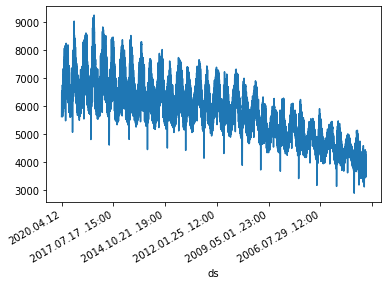

In [0]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

 뉴럴네트워크를 쓰기전에 피쳐의 scale를 맞춰주는 것은 아주 중요한 작업입니다. 따라서 표준화가 일반적으로 서용됩니다
 `tf.keras.utils.normalize` 메소드로 평균과 분산을 [0,1]로 지정 할 수 있습니다.

Note: The mean and standard deviation should only be computed using the training data.

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

이제 단변량 모델을 위한 데이터를 생성합니다.

우선 20개의 전기수요 관측치를 입력하면 다음 시간 스텝의 전기수요를 예측하도록 합니다.

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
print(x_val_uni[0])

[[-1.88129323]
 [-1.40474312]
 [-1.41111523]
 [-1.48308871]
 [-1.37215136]
 [-1.48653592]
 [-2.31553672]
 [-1.85841632]
 [-1.54743656]
 [-1.60196509]
 [-1.66140328]
 [-1.58013278]
 [-2.12103073]
 [-2.31887946]
 [-1.44684082]
 [-0.74141713]
 [-0.88254366]
 [-1.02659508]
 [-1.24533597]
 [-1.46522592]]


This is what the `univariate_data` function returns.

In [0]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.64238831]
 [-0.58545718]
 [ 0.10607322]
 [ 0.26130195]
 [ 0.19496935]
 [ 0.17982254]
 [ 0.24584175]
 [-0.60509581]
 [-0.54774684]
 [ 0.10168587]
 [ 0.25409416]
 [ 0.31718847]
 [ 0.17595749]
 [ 0.2036396 ]
 [-0.65220762]
 [-0.48621943]
 [ 0.53551151]
 [ 0.48296774]
 [ 0.2172195 ]
 [ 0.32335166]]

 Target temperature to predict
0.30642900896786884


위의 출력 결과는 univariate_data() 함수가 만든 20개의 과거 온도 데이터와 1개의 목표 예측 온도를 나타냅니다.

아래의 코드를 통해 이 데이터들을 그래프로 플롯하기 위한 함수를 만듭니다.

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

create_time_steps() 함수는 데이터의 길이를 이용해서 시간 스텝 값들을 만듭니다.

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

그리고 show_plot() 함수는 이 온도 데이터들을 matplotlib 그래프로 반환합니다.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

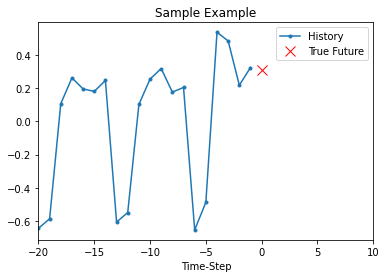

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

파란 마커가 20개의 과거 전기수요 데이터, 빨간 마커가 예측해야 할 미래의 (실제) 전기수요 데이터를 나타냅니다.


In [0]:
def baseline(history):
  return np.mean(history)

baseline 함수는 과거 20개의 데이터를 받아서 그 평균을 반환하는 함수입니다.

이 평균값을 첫번째 예측으로 사용해서 그래프로 나타내보겠습니다.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

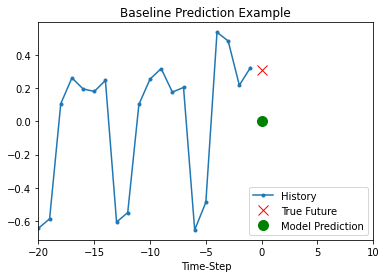

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

녹색 마커는 과거 전기수요 데이터의 평균값을 이용해서 예측한 지점을 나타냅니다.

### Recurrent neural network(순환신경망)
순환 신경망 (Recurrent Neural Network)은 시계열 데이터에 적합한 형태의 신경망입니다.

순환 신경망은 입력된 데이터들에 대한 정보를 유지하면서 시계열 데이터를 처리합니다.

###shuffle, batch, cache
tf.data를 이용해서 데이터셋을 shuffle, batch, cache하는 작업을 수행합니다.


In [0]:
BATCH_SIZE = 1
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

tf.data.Dataset의 from_tensor_slices()는 주어진 텐서들 ((x_train_uni, y_train_uni))을 첫번째 차원을 따라 슬라이스합니다.

모든 입력 텐서는 첫번째 차원과 같은 크기를 가져야합니다.
cache()는 데이터셋을 캐시, 즉 메모리 또는 파일에 보관합니다. 따라서 두번째 이터레이션부터는 캐시된 데이터를 사용합니다.

shuffle()는 데이터셋을 임의로 섞어줍니다. BUFFER_SIZE개로 이루어진 버퍼로부터 임의로 샘플을 뽑고, 뽑은 샘플은 다른 샘플로 대체합니다. 완벽한 셔플을 위해서 전체 데이터셋의 크기에 비해 크거나 같은 버퍼 크기가 요구됩니다.

batch()는 데이터셋의 항목들을 하나의 배치로 묶어줍니다.
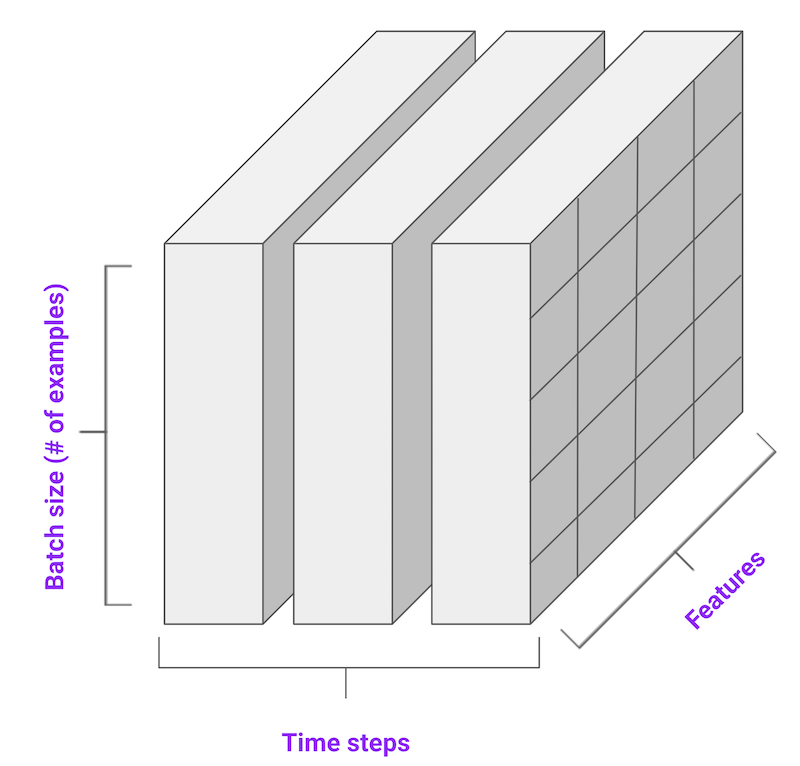

###LSTM(Long Short Term Memory)
LSTM은 순환 신경망 (RNN)의 특수한 형태입니다.

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
adam = tf.keras.optimizers.Adam(lr=0.01)#lr 조절
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [0]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(1, 1)


In [0]:
EVALUATION_INTERVAL = 200 #epoch당 200step
EPOCHS = 10 # 10번 이후로는 val_loss가 뛰어서 이 정도에서 멈춤 

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6514 - val_loss: 0.9028
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5150 - val_loss: 0.6834
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5162 - val_loss: 0.5613
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4236 - val_loss: 0.4529
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4644 - val_loss: 0.4153
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4370 - val_loss: 0.5040
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4666 - val_loss: 0.3690
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4318 - val_loss: 0.4679
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4267 - val_loss: 0.3393
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4680 - val_loss: 0.4285

#### Predict using the simple LSTM model
이제 이 간단한 LSTM 모델을 이용한 예측을 확인합니다.

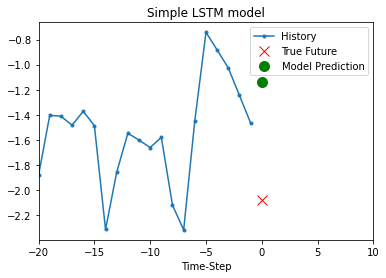

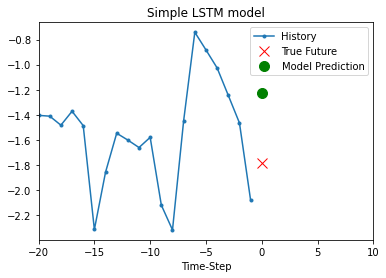

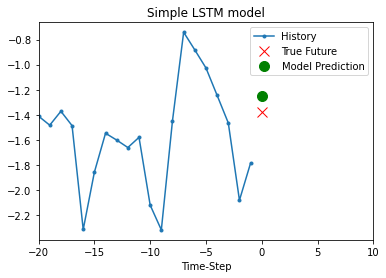

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

baseline() 함수가 했던 과거 20개의 온도 데이터의 평균을 사용한 예측보다 개선된 결과를 확인할 수 있습니다.